In [8]:
from transformers import AutoModelForQuestionAnswering
from nn_pruning.inference_model_patcher import InferenceModelPatcher

model = AutoModelForQuestionAnswering.from_pretrained("madlag/bert-base-uncased-squad1.1-pruned-x3.2-v2")

def compute_size(model):
    elems = 0
    for k, v in model.named_parameters():
        if "LayerNorm" not in k and "encoder" in k:
            elems += v.numel()
    return elems

original_count = compute_size(model)

# Create a model patcher
mp = InferenceModelPatcher(prune_heads=True, mode = "dense")
mp.add_pattern("bert.encoder\\.layer\\.[0-9]+\\.intermediate\\.dense", {})
mp.add_pattern("bert.encoder\\.layer\\.[0-9]+\\.output\\.dense", {})
# Patch model
mp.patch_model(model)    

new_count = compute_size(model)

print(original_count, new_count)

print(original_count / new_count)



removed heads 101, total_heads=144, percentage removed=0.7013888888888888
bert.encoder.layer.0.intermediate.dense, sparsity = 93.33
bert.encoder.layer.0.output.dense, sparsity = 93.33
bert.encoder.layer.1.intermediate.dense, sparsity = 90.49
bert.encoder.layer.1.output.dense, sparsity = 90.49
bert.encoder.layer.2.intermediate.dense, sparsity = 86.95
bert.encoder.layer.2.output.dense, sparsity = 86.95
bert.encoder.layer.3.intermediate.dense, sparsity = 86.30
bert.encoder.layer.3.output.dense, sparsity = 86.30
bert.encoder.layer.4.intermediate.dense, sparsity = 84.80
bert.encoder.layer.4.output.dense, sparsity = 84.80
bert.encoder.layer.5.intermediate.dense, sparsity = 86.10
bert.encoder.layer.5.output.dense, sparsity = 86.10
bert.encoder.layer.6.intermediate.dense, sparsity = 89.78
bert.encoder.layer.6.output.dense, sparsity = 89.78
bert.encoder.layer.7.intermediate.dense, sparsity = 90.79
bert.encoder.layer.7.output.dense, sparsity = 90.79
bert.encoder.layer.8.intermediate.dense, spars

In [ ]:
def print_sizes(model):
    for k, v in model.named_parameters():
        if "LayerNorm" not in k and "encoder" in k:
            print(k, v.shape)

print_sizes(model)

In [9]:
from matplotlib import pyplot

bert.encoder.layer.0.attention.self.query.weight torch.Size([448, 768])
bert.encoder.layer.0.attention.self.query.bias torch.Size([448])
bert.encoder.layer.0.attention.self.key.weight torch.Size([448, 768])
bert.encoder.layer.0.attention.self.key.bias torch.Size([448])
bert.encoder.layer.0.attention.self.value.weight torch.Size([448, 768])
bert.encoder.layer.0.attention.self.value.bias torch.Size([448])
bert.encoder.layer.0.attention.output.dense.weight torch.Size([768, 448])
bert.encoder.layer.0.attention.output.dense.bias torch.Size([768])
bert.encoder.layer.0.intermediate.dense.linear.weight torch.Size([205, 768])
bert.encoder.layer.0.intermediate.dense.linear.bias torch.Size([205])
bert.encoder.layer.0.output.dense.linear.weight torch.Size([768, 205])
bert.encoder.layer.0.output.dense.linear.bias torch.Size([768])
bert.encoder.layer.1.attention.self.query.weight torch.Size([128, 768])
bert.encoder.layer.1.attention.self.query.bias torch.Size([128])
bert.encoder.layer.1.attention.se

In [21]:
from matplotlib import pyplot

tensor(1.)


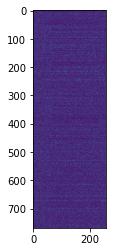

In [29]:
def show(name):
    m = a[name].abs()
    print((m !=0).sum() / m.numel())
    pyplot.imshow(m.cpu().detach().numpy())
    
#name = "bert.encoder.layer.11.output.dense.linear.weight"
name = "bert.encoder.layer.4.attention.output.dense.weight"
show(name)

In [23]:
for k in dir(model):
    if "parameter" in k:
        print(k)

_parameters
named_parameters
num_parameters
parameters
register_parameter


In [24]:
print(model.num_parameters())

37382408


In [48]:
def model_part_size(model_name, white_list, black_list):
    from transformers import AutoModelForQuestionAnswering
    from pytorch_block_sparse import BlockSparseModelPatcher

    model = AutoModelForQuestionAnswering.from_pretrained(model_name)

    a = {k:v for k,v in model.named_parameters()}
    total = 0
    for k,v in a.items():
        def check(x):            
            for bl in black_list:
                if bl in x:
                    return False
            for wl in white_list:
                if wl not in x:
                    return False
            return True
        if not check(k):
            continue
        
        total += v.numel()
    return total

    
total_distilbert = model_part_size("distilbert-base-uncased-distilled-squad",
                                    white_list=["weight"],
                                    black_list=["embeddings", "layer_norm", "qa"])

print(total_distilbert)


from transformers import AutoModelForQuestionAnswering
from pytorch_block_sparse import BlockSparseModelPatcher

model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased-distilled-squad")


a = {k:v for k,v in model.named_parameters()}
total_distilbert = 0
for k,v in a.items():
    if "weight" in k and "embeddings" not in k and "layer_norm" not in k and "qa" not in k:
        total_distilbert += v.numel()
        print(k, v.numel())
print(total_distilbert)




42467328
distilbert.transformer.layer.0.attention.q_lin.weight 589824
distilbert.transformer.layer.0.attention.k_lin.weight 589824
distilbert.transformer.layer.0.attention.v_lin.weight 589824
distilbert.transformer.layer.0.attention.out_lin.weight 589824
distilbert.transformer.layer.0.ffn.lin1.weight 2359296
distilbert.transformer.layer.0.ffn.lin2.weight 2359296
distilbert.transformer.layer.1.attention.q_lin.weight 589824
distilbert.transformer.layer.1.attention.k_lin.weight 589824
distilbert.transformer.layer.1.attention.v_lin.weight 589824
distilbert.transformer.layer.1.attention.out_lin.weight 589824
distilbert.transformer.layer.1.ffn.lin1.weight 2359296
distilbert.transformer.layer.1.ffn.lin2.weight 2359296
distilbert.transformer.layer.2.attention.q_lin.weight 589824
distilbert.transformer.layer.2.attention.k_lin.weight 589824
distilbert.transformer.layer.2.attention.v_lin.weight 589824
distilbert.transformer.layer.2.attention.out_lin.weight 589824
distilbert.transformer.layer.2.ff

In [46]:
from transformers import AutoModelForQuestionAnswering
from pytorch_block_sparse import BlockSparseModelPatcher

model = AutoModelForQuestionAnswering.from_pretrained("csarron/bert-base-uncased-squad-v1")


a = {k:v for k,v in model.named_parameters()}
total = 0
for k,v in a.items():
    if "weight" in k and "embeddings" not in k and "LayerNorm" not in k and "qa" not in k:
        total += v.numel()
        print(k, v.numel())
print(total)



print(total_distilbert / total)

bert.encoder.layer.0.attention.self.query.weight 589824
bert.encoder.layer.0.attention.self.key.weight 589824
bert.encoder.layer.0.attention.self.value.weight 589824
bert.encoder.layer.0.attention.output.dense.weight 589824
bert.encoder.layer.0.intermediate.dense.weight 2359296
bert.encoder.layer.0.output.dense.weight 2359296
bert.encoder.layer.1.attention.self.query.weight 589824
bert.encoder.layer.1.attention.self.key.weight 589824
bert.encoder.layer.1.attention.self.value.weight 589824
bert.encoder.layer.1.attention.output.dense.weight 589824
bert.encoder.layer.1.intermediate.dense.weight 2359296
bert.encoder.layer.1.output.dense.weight 2359296
bert.encoder.layer.2.attention.self.query.weight 589824
bert.encoder.layer.2.attention.self.key.weight 589824
bert.encoder.layer.2.attention.self.value.weight 589824
bert.encoder.layer.2.attention.output.dense.weight 589824
bert.encoder.layer.2.intermediate.dense.weight 2359296
bert.encoder.layer.2.output.dense.weight 2359296
bert.encoder.lay

In [49]:
from transformers import AutoModelForQuestionAnswering
from pytorch_block_sparse import BlockSparseModelPatcher

model = AutoModelForQuestionAnswering.from_pretrained("madlag/bert-base-uncased-squad1.1-pruned-x3.2-v2")



ModuleAttributeError: 'BertForQuestionAnswering' object has no attribute 'named_parameter'

In [70]:
import re
import torch
    
params = {}
for name, parameter in model.named_parameters():
    params[name] = parameter
    

for layer_number in range(12):
    n0 = f"bert.encoder.layer.{layer_number}.intermediate.dense.weight"
    n1 = f"bert.encoder.layer.{layer_number}.output.dense.weight"
    
    output_mask = (params[n0].abs().sum(1) != 0)
    input_mask = (params[n1].abs().sum(0) != 0)
    
    print(output_mask.shape)
    print(input_mask.shape)
    
    with torch.no_grad():        
        params[n0][input_mask]  = 0
        params[n1][:, output_mask]  = 0
        



torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
torch.Size([3072])
